In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.datasets import make_regression

## 1.Gradient Descent

For unconstrained optimization problem whose objective function $f(x)$ is smooth convex function, sequence ${x_{k}}$ that has following iteration form converges to problem's solution $x*$ such that $x^ = \underset{x}{argmin} f(x)$ under appropriate step size $t_k$ $$ x^{(k+1)} = x^{(k)} - t_k \nabla f(x^{(k)})$$

## (1) Linear Regression(no intercept)

단순 선형 회귀모델 $y_i =\beta_1 x_{i1} + \beta_2 x_{i2} + \epsilon_i$ or $y= X\beta+\epsilon$의 SSE는 다음과 같다.
$f(\beta) = \sum_i^n \epsilon_i^2 = \epsilon^t\epsilon \ \quad= (y-X\beta)^t(y-X\beta) \ \quad = y^ty-2\beta^tX^ty + \beta^tX^tX\beta$

이때 목적함수 $f(\beta)$는 L2-Norm의 Affine Transformation 꼴이므로 Convex Function이다.
따라서 이에 대한 Convex Optimization Problem을 다음과 같이 설계 할 수 있다.
$$\underset{\beta}{min} {y^ty-2\beta^tX^ty+\beta^tX^tX\beta}$$

이에 대한 Gradient를 구하면 다음과 같다.
$\frac{\delta}{\delta \beta}{y^ty-2\beta^tX^ty+\beta^tX^tX\beta} \ \quad = {-2y^tX+2X^tX\beta}$

따라서 이터레이션 폼은 다음과 같은 형태를 띈다.
$x^+ = x - t \nabla f(x) \ \quad = x - 2t(X^tX\beta-y^tX)$

* 우선 위에서 구한 공식을 이용해 현재의 $\beta$값을 넣으면 현재의 Gradient를 계산해주는 함수를 짜자.

In [14]:
def lin_gradient(beta) : 
    return((x_mat.transpose()@x_mat@beta-x_mat.transpose()@y_mat))

- ### sklearn에 내장되어 있는 함수를 이용해 Y,X를 generate 시킨다(Var(e)=1)

In [107]:
x_mat, y_mat, beta = sklearn.datasets.make_regression(n_samples=1000, n_features=2, n_informative=2, n_targets=1, bias=0.0, effective_rank=None, noise=1, shuffle=True, coef=True, random_state=None)

In [108]:
beta

array([35.03671634, 90.2456229 ])

- 처음으로 Initial Point 및 Place Holder 만들어주자

In [109]:
## 기본값 설정 (beta-temporary value)
beta_init = [30,80]

## 현재값 설정 (beta-temporary value)
beta_temp = beta_init

## 결과물 공간 (Gradient Descent Result A)
GD_result_A = pd.DataFrame([beta_init],columns=["beta0","beta1"])

## step size 지정
t_fixed= 0.00001

In [110]:
for i in range(1000) : 
    beta_temp = beta_temp - 2*t_fixed*(lin_gradient(beta_temp))
    GD_result_A = GD_result_A.append(pd.DataFrame(np.array([beta_temp]),columns=["beta0","beta1"]),ignore_index=True)
    if sum(lin_gradient(beta_temp)**2)**(1/2) < 0.0001 : break

In [111]:
GD_result_A

,beta0,beta1
0,30.000000,80.000000
1,30.100324,80.207800
2,30.198656,80.411380
3,30.295036,80.610827
4,30.389503,80.806223
...,...,...
908,35.055911,90.232488
909,35.055911,90.232488
910,35.055911,90.232488
911,35.055911,90.232488


- 위에 나온 회귀계수값과 값이 상당히 유사하다

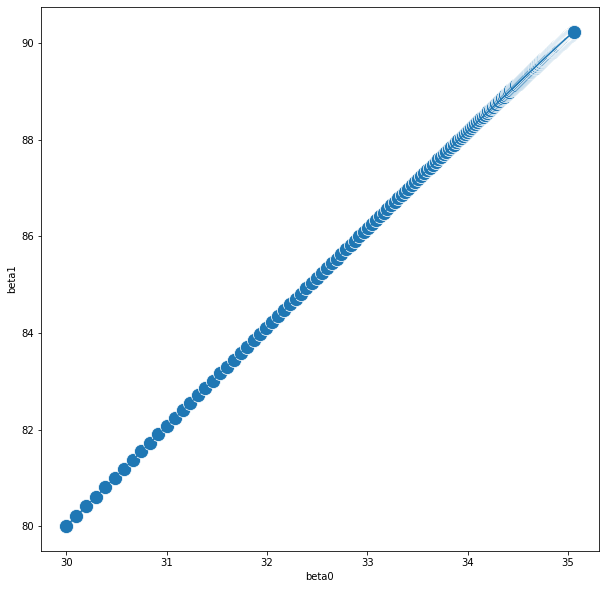

In [112]:
plt.figure(figsize=(10,10))
sns.lineplot(x="beta0", y="beta1",
                  sort=False, data=GD_result_A)
sns.scatterplot(x="beta0", y="beta1",data=GD_result_A,s=200,marker="o")
plt.show()

### Backtracking Line Search를 통해 step size를 조정한다

Backtracking Line Search는 다음과 같은 알고리즘이다.

우선 initial step size $t_0$를 임의로 정해준다.
알고리즘의 하이퍼 파라미터인 $\alpha \in (0,0.5] , \beta \in (0,1)$를 임의로 정해주자.
다음의 조건을 체크하고 조건이 성립하지 않을 때 까지 $t = \beta t$를 넣어주며 t를 축소해주자.
$ f(x^+) > f(x) - \alpha t \parallel \nabla f(x) \parallel_2^2$
조건이 성립하지 않는다면 구해진 t값을 이용해서 Gradient Descent Step을 1회 진행하자.

In [113]:
def backtracking(alpha,t) : 
    beta_plus = beta_temp - 2*t_temp*(x_mat.transpose()@x_mat@beta_temp-x_mat.transpose()@y_mat)
    res_plus = sum((y_mat-x_mat@beta_plus)**2)
    res = x_mat.transpose()@x_mat@beta_temp-x_mat.transpose()@y_mat
    res_temp = sum((y_mat-x_mat@beta_temp)**2)-alpha*t_temp*sum(res**2)
    return(res_plus>res_temp)

In [356]:
## 모수 초기값
beta_init = np.array([30,80])

## 모수 현재값
beta_temp = beta_init

## 스텝 초기값
t_init = np.array([0.5])

## 스텝 현재값
t_temp = t_init

## 전체 결과물 저장소
GD_result_B = pd.DataFrame([[*t_init,*beta_init]],columns=["Step","beta0","beta1"])

## 하이퍼 파라미터
alpha = 0.5
beta = 0.7

In [357]:
for i in range(1000) : 
    while (backtracking(alpha,t_temp)):
        t_temp = t_temp * beta
        beta_temp = beta_temp - 2*t_temp*lin_gradient(beta_temp)
        GD_result_B = GD_result_B.append(pd.DataFrame([[*t_temp,*beta_temp]],columns=["Step","beta0","beta1"]),ignore_index=True)
    if sum(lin_gradient(beta_temp)**2)**(1/2) < 0.01 : break

In [358]:
GD_result_B

,Step,beta0,beta1
0,0.500000,3.000000e+01,8.000000e+01
1,0.350000,-1.967708e+04,-6.131124e+04
2,0.245000,8.973816e+06,3.308102e+07
3,0.171500,-2.839960e+09,-1.249150e+10
4,0.120050,6.221659e+11,3.299692e+12
5,0.084035,-9.403161e+13,-6.094225e+14
6,0.058824,9.755718e+15,7.863641e+16
7,0.041177,-6.895853e+17,-7.081632e+18
8,0.028824,3.280697e+19,4.444302e+20
9,0.020177,-1.028030e+21,-1.939613e+22


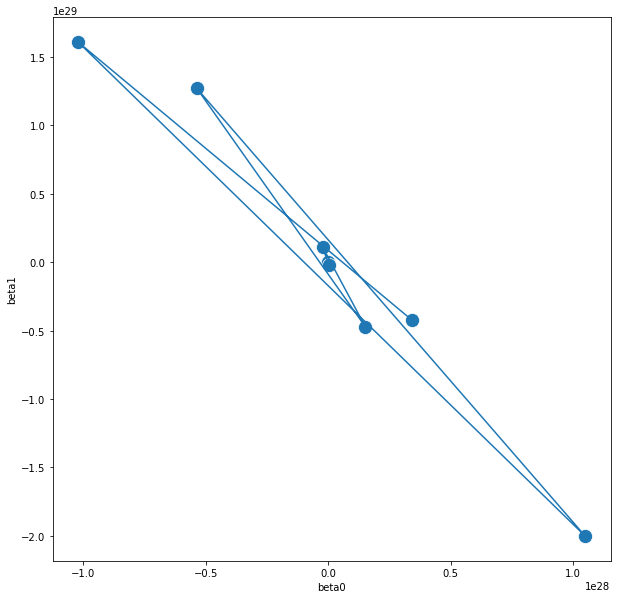

In [359]:
plt.figure(figsize=(10,10))
sns.lineplot(x="beta0", y="beta1",
                  sort=False, data=GD_result_B)
sns.scatterplot(x="beta0", y="beta1",data=GD_result_B,s=200,marker="o")
plt.show()

- gradient descent와 다르게 step size를 다르게 줌으로 인해서 움직이는 보폭이 다름을 확인할 수 있다.

 ### Exact Line Search 를 적용해본다.

Gradient Descent에서 Convergence Analysis를 해보면 Strong Convexity Constant $\mu$와 Lipschitz Constant L을 찾아서 평균의 역수를 사용함으로써 최적의 Exact Step Size를 찾을 수 있다. 많은 방식이 있지만 이 문제에 대해서는 아래를 만족하는 Constant를 찾아서 구해줄 수 있다.
$ LI \prec \nabla^2 f(x) \prec mI$

$\nabla^2 f(x) = \nabla { \nabla f(x)} \\ \qquad \quad = \nabla {-2y^tX+2X^tX\beta } \\ \qquad \quad = 2X^tX$

Quadratic Form Theorem을 쓰면 아래와 같은 관계식을 얻을 수 있다.
$\lambda_p \leq \frac{x^t A x}{x^t x} \leq \lambda_1$
$\lambda_p x^t x \leq x^t A x \leq \lambda_1 x^t x$
$ \lambda_p I \leq A \leq \lambda_1 I$
따라서 Hessian Matrix의 아이젠 밸류의 최대값과 최소값이 Lipschit Constant L과 Strong Convexity Constant $\mu$가 된다.
따라서 아래와 같이 분해를 해준 뒤 이론상의 정확한 step size를 찾아주자

In [118]:
eigen = np.linalg.svd(2*x_mat.transpose()@x_mat)[1]
t_fixed = 2/(np.min(eigen)+np.max(eigen))
t_fixed

0.0005055396216550964

In [119]:
## 초기값
beta_init = [30,80]

## 현재값
beta_temp = beta_init

## 전체 결과물 저장소
GD_result_C = pd.DataFrame([beta_init],columns=["beta0","beta1"])

In [120]:
for i in range(1000) : 
    beta_temp = beta_temp - 2*t_fixed*((x_mat.transpose()@x_mat@beta_temp-x_mat.transpose()@y_mat))
    GD_result_C = GD_result_C.append(pd.DataFrame(np.array([beta_temp]),columns=["beta0","beta1"]),ignore_index=True)
    if sum(lin_gradient(beta_temp)**2)**(1/2) < 0.01 : break

In [121]:
GD_result_C

,beta0,beta1
0,30.000000,80.000000
1,35.071780,90.505099
2,35.053017,90.226631
3,35.055920,90.232644
4,35.055909,90.232485


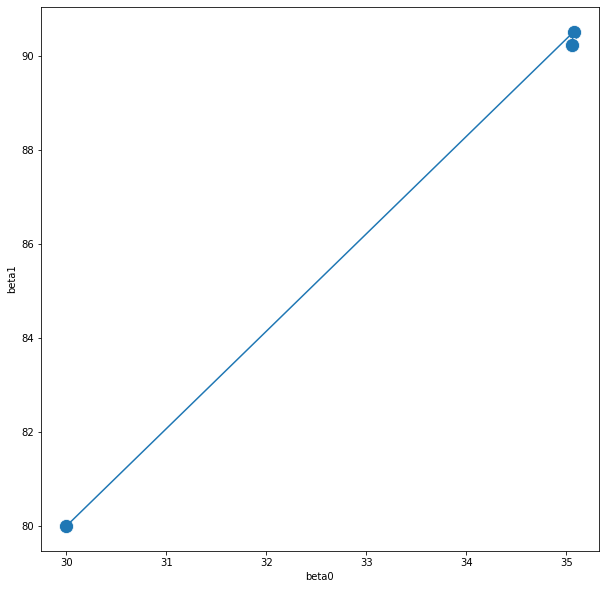

In [122]:
plt.figure(figsize=(10,10))
sns.lineplot(x="beta0", y="beta1",
                  sort=False, data=GD_result_C)
sns.scatterplot(x="beta0", y="beta1",data=GD_result_C,s=200,marker="o")
plt.show()

### target value와 세가지 방법을 plotting 시킨다.

In [123]:
target_beta = [35.03671634, 90.2456229]
GD_Total_Score = pd.concat([GD_result_A.apply(lambda x : sum((target_beta-x)**2)/2 ,axis=1),GD_result_B.apply(lambda x : sum((target_beta-x[1:4])**2)/2 ,axis=1),GD_result_C.apply(lambda x : sum((target_beta-x)**2)/2 ,axis=1)],axis=1)
GD_Total_Score.columns = ["Fixed Step","BackTracking","Exact"]

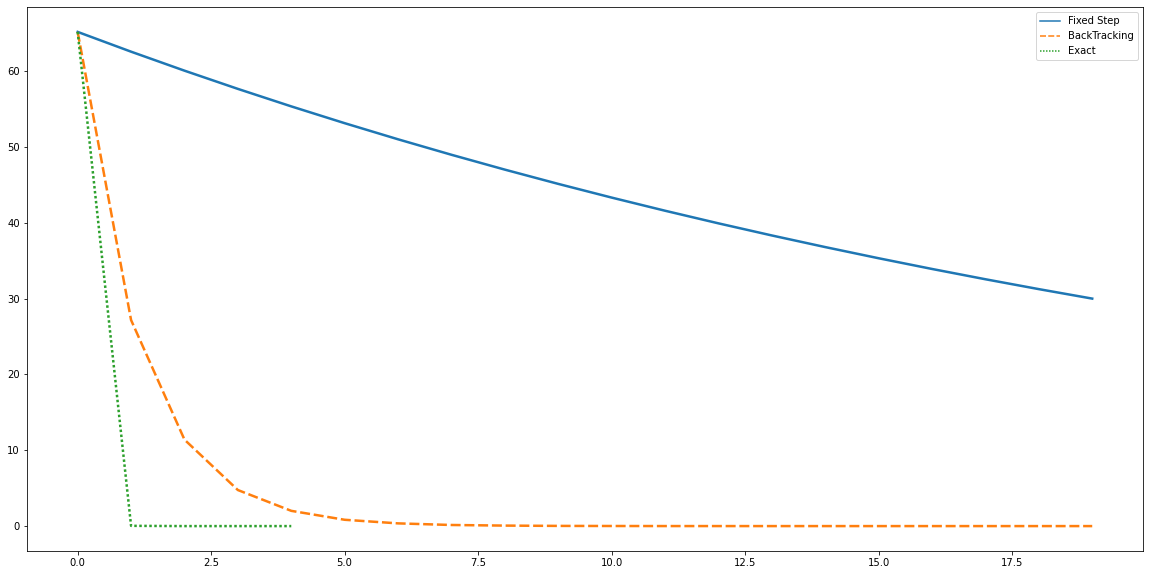

In [124]:
plt.figure(figsize=(20,10))
sns.lineplot(data=GD_Total_Score.iloc[:20], palette="tab10", linewidth=2.5)
plt.show()

### Comment: 
- Gradient Descent보다 Backtracking, Exact line Search를 했을 때 처음에는 차이가 크나 나중에 갈수록 오차가 줄어드는 것을 확인할 수 있다.
- 잘 수렴하지 못하는 Gradient Descent와 다르게 Backtracking, Exact line search를 사용하면 수렴이 잘 됨을 확인할 수 있다.
- Exact Line Search를 위해서 Hessian Matrix를 감싸는 적절한 범위를 찾아야 하는데 이를 위해서는 Spectral Decomposition을 해줌으로써 구할 수 있다.
- Exact Line Search를 통해서 구한 Step Size는 Gradient Descent 수렴의 분기가 된다.

## (2) Logistic Regression (no intercept model)

Logistic Regression의 cost function은 Maximum likelihood estimation을 기반으로 한 cost function으로 정의한다.

$cost(f(x),y)$ = 
$-log(f(x))$ if y = 1 or
$-log(1-f(x))$ if y = 0

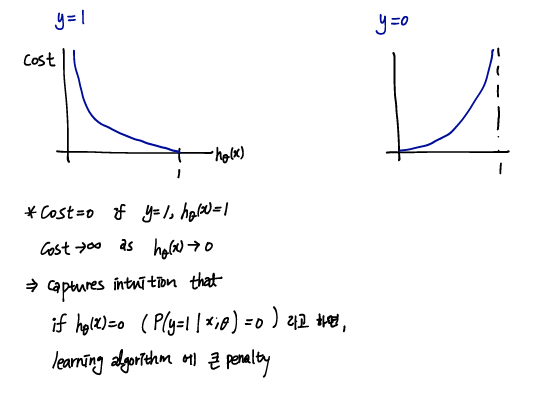

즉, $y=1$ 일 때, $f(x)=1$ 이면 cost=0 이고, $y=0$ 일 때, $f(x)=0$ 이면 cost는 무한대로 발산한다. (여기서 $y$는 1 혹은 0만 가지는 binary output만 가진다. 참값이 predicted와 다를 경우에 penalty를 부여한다고 볼 수 있다.)

위의 그림에서도 볼 수 있듯이 convex 형태를 가진다.

최종적으로 logistic regression의 cost function은 다음과 같이 표기할 수 있다.

$J(\beta) = - \frac{1}{m} 
\sum_{i=1}^{m} \left[ 
y^{(i)} \log f_\beta (x) +
(1-y^{(i)}) \log \left( 1-f_\beta (x) \right)
\right]$

이 함수는 convex이고, 따라서 gradient descent 알고리즘을 적용시킬 수 있게 된다. 여기서 위의 cost function의 도함수는 

$\frac{\partial}{\partial \beta_j} J(\beta)
= \frac{1}{m} \sum_{i=1}^{m} \left( f_\beta(x^{(i)}) - y^{(i)} \right) x_j^{(i)}$ 이고,

따라서 

$\beta_j := \beta_j - \gamma \frac{\partial}{\partial \beta_j} J(\beta)$ 를 진행하여 gradient descent를 한다.

### 이번에도 sklearn에 내장되어 있는 함수를 통해 random number를 generate시킨다.

In [224]:
from sklearn.datasets import make_classification

In [328]:
x_mat, y_mat = make_classification(n_samples=1000, n_features=2, n_informative=1, n_redundant=0,
                           n_clusters_per_class=1, random_state=4)

In [329]:
import statsmodels.api as sm
logit_model=sm.Logit(y_mat,x_mat)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.021809
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Fri, 13 Nov 2020   Pseudo R-squ.:                  0.9685
Time:                        22:22:03   Log-Likelihood:                -21.809
converged:                       True   LL-Null:                       -693.15
Covariance Type:            nonrobust   LLR p-value:                6.015e-294
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1954      0.464      0.421      0.674      -0.715       1.106
x2             7.4000      0

fitting을 시킨 결과 $\beta_1 = 0.1954, \beta_2 = 7.4$ 가 나왔다

####  logistic(sigmoid) 함수와 cost function을 정의한다

In [283]:
def sigmoid(X, beta):
    
    z = np.dot(X, beta)
    
    return 1.0 / ( 1.0 + np.exp(-z))

In [284]:
def loss(fx, y):
    return (-y.dot(np.log(fx)) - (1 - y).dot(np.log(1 - fx)))

#### gradient를 정의한다

In [318]:
# Gradient Descent function to minimize the Logistic Regression Cost Function.
def logiGradient(X, y,beta):
        fx = sigmoid(X, beta)
        error = fx - y
        grad = X.T.dot(error)
        return grad

In [343]:
## 모수 초기값
beta_init = np.array([0,10])

## 모수 현재값
beta_temp = beta_init

## 전체 결과물 저장소
GDlogi_result_A = pd.DataFrame([beta_init],columns=["beta0","beta1"])

## 하이퍼 파라미터 
t_fixed= 0.01 #learning rate
num_iter = 1000

In [320]:
for i in range(num_iter) : 
    beta_temp = beta_temp - t_fixed*(logiGradient(x_mat,y_mat,beta_temp))
    GDlogi_result_A = GDlogi_result_A.append(pd.DataFrame(np.array([beta_temp]),columns=["beta0","beta1"]),ignore_index=True)
    if sum(logiGradient(x_mat,y_mat,beta_temp)**2)**(1/2) < 0.0001 : break

In [321]:
GDlogi_result_A

,beta0,beta1
0,0.000000,10.000000
1,0.009016,9.986305
2,0.017846,9.972640
3,0.026493,9.959008
4,0.034959,9.945407
...,...,...
996,0.195395,7.400154
997,0.195395,7.400152
998,0.195395,7.400150
999,0.195394,7.400148


#### 결과값을 확인해보면 mle로 구한(NR) 위의 계수들과 거의 비슷하게 수렴함을 확인할 수 있다.

#### cost가 얼마나 줄어들었는지 plot으로 확인해보자.

In [344]:
cost = []
for i in range(num_iter):
        fx = sigmoid(x_mat, beta_temp)
        error = fx - y_mat
        grad = x_mat.T.dot(error)
        beta_temp = beta_temp - t_fixed*(logiGradient(x_mat,y_mat,beta_temp))
        
        cost.append(loss(fx, y_mat))

Text(0.5, 1.0, 'Logistic Regression')

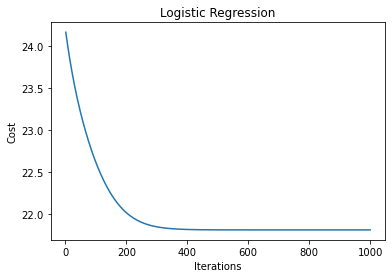

In [345]:
plt.plot(range(1, len(cost) + 1), cost)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Logistic Regression')

### Backtracking Line Search를 적용해 step size를 찾아본다.

로지스틱 regression의 목적함수가
$J(\beta) = - \frac{1}{m} 
\sum_{i=1}^{m} \left[ 
y^{(i)} \log f_\beta (x) +
(1-y^{(i)}) \log \left( 1-f_\beta (x) \right)
\right]$ 이므로, 각각 beta_plus 와 beta_temp 값을 넣어 비교하여 진행한다.

In [346]:
def logi_backtracking(alpha,t) : 
    beta_plus = beta_temp - t_temp*logiGradient(x_mat, y_mat, beta_temp)
    obj_plus = loss(sigmoid(x_mat,beta_plus), y_mat)
    obj = loss(sigmoid(x_mat,beta_temp),y_mat)
    obj_temp = obj-alpha*t_temp*logiGradient(x_mat, y_mat, beta_temp)
    return(obj_plus>obj_temp)

In [372]:
## 모수 초기값
beta_init = np.array([0,10])

## 모수 현재값
beta_temp = beta_init

## 스텝 초기값
t_init = np.array([0.5])

## 스텝 현재값
t_temp = t_init

## 전체 결과물 저장소
GDlogi_result_B = pd.DataFrame([[*t_init,*beta_init]],columns=["Step","beta0","beta1"])

## 하이퍼 파라미터
alpha = 0.5
beta = 0.7

In [366]:
for i in range(num_iter) : 
    while (backtracking(alpha,t_temp)):
        t_temp = t_temp * beta
        beta_temp = beta_temp - t_temp*(logiGradient(x_mat,y_mat,beta_temp))
        GDlogi_result_B = GDlogi_result_B.append(pd.DataFrame([[*t_temp,*beta_temp]],columns=["Step","beta0","beta1"]),ignore_index=True)
    if sum(logiGradient(x_mat,y_mat,beta_temp)**2)**(1/2) < 0.0000001 : break

In [367]:
GDlogi_result_B

,Step,beta0,beta1
0,0.500000,0.000000,10.000000
1,0.350000,0.315544,9.520661
2,0.245000,0.349671,9.222354
3,0.171500,0.346094,9.031507
4,0.120050,0.338790,8.906380
5,0.084035,0.332619,8.822921
6,0.058824,0.328034,8.766526
7,0.041177,0.324754,8.728043
8,0.028824,0.322438,8.701592
9,0.020177,0.320811,8.683314


- logistic regression에서는 backtracking을 사용할 경우에는 step size가 너무 작아져버려서 수렴을 하지 못한다는 점이 생긴다.

#### 위와 똑같이 cost가 얼마나 줄어들었나 확인해준다.

In [373]:
cost = []
for i in range(num_iter):
        fx = sigmoid(x_mat, beta_temp)
        error = fx - y_mat
        grad = x_mat.T.dot(error)
        while (backtracking(alpha,t_temp)):
            t_temp = t_temp * beta
            beta_temp = beta_temp - t_temp*(logiGradient(x_mat,y_mat,beta_temp))
        
        cost.append(loss(fx, y_mat))

Text(0.5, 1.0, 'Logistic Regression: Backtracking')

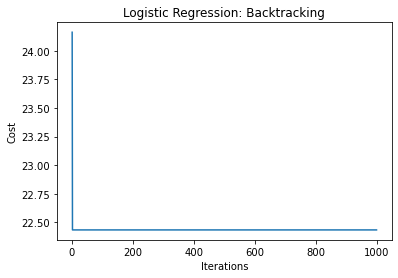

In [374]:
plt.plot(range(1, len(cost) + 1), cost)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Logistic Regression: Backtracking')

- 목적함수를 minimize시키는데 빨리 도달했으나 위와 같이 Newton Raphson으로 구한 estimator와 값이 차이가 난다(이유는 잘 모르겠습니다)

### 마지막으로 exact line search를 적용해 본다.

마찬가지로 아래와 같은 성질을 이용하여 구한다.

$ LI \prec \nabla^2 f(x) \prec mI$




$\nabla^2 f(x) = X^tDX$


이고, 여기서 D는 $d(ii) = sigmoid(\beta^T x(i)) sigmoid(-\beta^T x(i))$ 로 diagonal element를 가지는 대각행렬이다.


여기서 위의 Hessian Matrix가 Spectral Decomposition form이므로, 대각행렬의 원소들이 eigenvalue가 된다.

또한 위의 linear regression과 같이 step size를 $2 / (\lambda_(min)+\lambda_(max))$ 로 잡아준다

In [385]:
beta = np.array([0.1954,7.4]) #assume that we know the true beta

Hessian = sigmoid(x_mat,beta)*sigmoid(x_mat,-beta)

In [389]:
lambda_max = max(Hessian)
lambda_min = min(Hessian)

In [390]:
t_revised = 2/(lambda_max+lambda_min)
t_revised

8.06843199872253

In [391]:
## 초기값
beta_init = [0,10]

## 현재값
beta_temp = beta_init

## 전체 결과물 저장소
GDlogi_result_C = pd.DataFrame([beta_init],columns=["beta0","beta1"])

In [392]:
for i in range(num_iter) : 
    beta_temp = beta_temp - t_revised*(logiGradient(x_mat,y_mat,beta_temp))
    GDlogi_result_C = GDlogi_result_C.append(pd.DataFrame(np.array([beta_temp]),columns=["beta0","beta1"]),ignore_index=True)
    if sum(logiGradient(x_mat,y_mat,beta_temp)**2)**(1/2) < 0.0001 : break

<ipython-input-283-1400af30e7c2>:5: RuntimeWarning: overflow encountered in exp
  return 1.0 / ( 1.0 + np.exp(-z))


In [393]:
GDlogi_result_C

,beta0,beta1
0,0.000000,10.000000
1,7.274135,-1.050033
2,-3076.750575,4562.722778
3,-1975.634911,5084.108034
4,-1758.356406,5127.789675
...,...,...
996,69.266018,551.347812
997,67.182793,535.818156
998,65.099647,520.288495
999,63.016628,504.758825
